In [1]:
import numpy as np

class Optimizer:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    
    def update(self, w, b, dw, db):
        raise NotImplementedError
    
class Momentum(Optimizer):
    def __init__(self, alpha=0.01, beta=0.9):
        super().__init__(alpha)
        self.beta = beta
        self.vdw = None
        self.vdb = None

    def update(self, weights, bias, dw, db):
        if self.vdw is None:
            self.vdw = [np.zeros_like(w) for w in weights]
            self.vdb = [np.zeros_like(b) for b in bias]

        for i in range(len(weights)):
            self.vdw[i] = self.beta*self.vdw[i] + (1-self.beta)*dw[i]
            self.vdb[i] = self.beta*self.vdb[i] + (1-self.beta)*db[i]
            weights[i] = weights[i] - self.alpha * self.vdw[i]
            bias[i] = bias[i] - self.alpha * self.vdb[i]
        return weights, bias
    

class RMSprop(Optimizer):
    def __init__(self, alpha=0.01, beta2 = 0.999):
        super().__init__(alpha)
        self.sdw = None
        self.sdb = None
        self.beta2 = beta2
        self.epsilon = 10e-8
        self.t = 0

    def update(self, weights, bias, dw, db):
        if self.sdw is None:
            self.sdw = [np.zeros_like(w) for w in weights]
            self.sdb = [np.zeros_like(b) for b in bias]
        
        for i in range(len(weights)):
            self.sdw[i] = self.beta2 * self.sdw[i] + (1-self.beta2) * dw[i]**2
            self.sdb[i] = self.beta2 * self.sdb[i] + (1-self.beta2) * db[i]**2
            weights[i] -= self.alpha * (dw[i]/np.sqrt(self.sdw[i]+self.epsilon))
            bias[i] -= self.alpha * (db[i]/np.sqrt(self.sdb[i]+self.epsilon))
        return weights, bias
    


class Adam(Optimizer):
    def __init__(self, alpha=0.01, beta1 = 0.9, beta2 = 0.999):
        super().__init__(alpha)
        self.sdw = None
        self.sdb = None
        self.vdw = None
        self.vdb = None
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 1e-8
        self.t = 0

    def update(self, weights, bias, dw, db):
        if self.sdw is None:
            self.sdw = [np.zeros_like(w) for w in weights]
            self.sdb = [np.zeros_like(b) for b in bias]
        if self.vdw is None:
            self.vdw = [np.zeros_like(w) for w in weights]
            self.vdb = [np.zeros_like(b) for b in bias]
        
        self.t += 1

        for i in range(len(weights)):
            self.sdw[i] = self.beta2 * self.sdw[i] + (1-self.beta2) * dw[i]**2
            self.sdb[i] = self.beta2 * self.sdb[i] + (1-self.beta2) * db[i]**2
            self.vdw[i] = self.beta1*self.vdw[i] + (1-self.beta1)*dw[i]
            self.vdb[i] = self.beta1*self.vdb[i] + (1-self.beta1)*db[i]

            vdw_corr = self.vdw[i]/(1-self.beta1**self.t)
            vdb_corr = self.vdb[i]/(1-self.beta1**self.t)
            sdw_corr = self.sdw[i]/(1-self.beta2**self.t)
            sdb_corr = self.sdb[i]/(1-self.beta2**self.t)

            weights[i] -= self.alpha * (vdw_corr/np.sqrt(sdw_corr+self.epsilon))
            bias[i] -= self.alpha * (vdb_corr/np.sqrt(sdb_corr+self.epsilon))
        return weights, bias

In [2]:
import matplotlib.pyplot as plt

'''
ANN code from the last chapter
adding L2 regularization, dropout, Momentum, softmax
'''

class MyNeuralNetwork:

    '''
    num_layer: number of layer including input layer
    layer_size: units of hidden layer

    weights and bias are hidden layers
    '''
    def __init__(
            self, 
            layer_size: list, 
            optimizer: Optimizer = None, 
            L2: bool = False, 
            output_activation: str = "sigmoid", 
            lambd = 0.1,
            dropout = 1.0,  ## keep_prob
            alpha = 0.001
            ):
        self.num_layer = len(layer_size)
        self.layer_size = layer_size
        self.optimizer = optimizer
        self.output_activation = output_activation
        self.L2 = L2
        self.lambd = lambd
        self.dropout = dropout
        self.alpha = alpha

        self.weights = []
        self.bias = []

        self.gamma = []
        self.beta = []

        # initializing weights and bias
        for i in range(len(layer_size)-1):
            self.weights.append(np.random.rand(layer_size[i+1], layer_size[i]) * 0.01)
            self.bias.append(np.zeros((layer_size[i+1], 1)))

            self.gamma.append(np.ones((layer_size[i+1], 1)))
            self.beta.append(np.zeros((layer_size[i+1], 1)))

    # forward propagation
    def forward(self, a0):
        a = a0
        self.z_value = []
        self.a_value = [a0]
        self.masks = []
        self.bn_cache = []
        
        for idx, (w,b) in enumerate(zip(self.weights, self.bias)):
            z = np.dot(w, a) + b
            if idx == len(self.weights) - 1:  # use sigmoid for output layer
                if self.output_activation == "sigmoid":
                    a = self.sigmoid(z)
                elif self.output_activation == "softmax":
                    a = self.softmax(z)
            else:  # hidden layers use ReLU function
                # Batch Norm
                mu = np.mean(z, axis=1, keepdims=True)
                sigma = np.var(z, axis=1, keepdims=True)
                z_norm = (z - mu)/np.sqrt(sigma + 1e-8)
                z_tilde = self.gamma[idx] * z_norm + self.beta[idx]

                self.bn_cache.append([z, mu, sigma, z_norm])

                a = self.ReLU(z_tilde)
                if self.dropout < 1.0:
                    mask = np.random.rand(a.shape[0], a.shape[1]) < self.dropout
                    a = a * mask
                    a /= self.dropout
                    self.masks.append(mask)
            self.z_value.append(z)
            self.a_value.append(a)
            
        return a
    

    # backward propagation
    def backward(self, y):
        m = y.shape[1]
        y_hat = self.a_value[-1]
        L = self.num_layer - 1
        dw_value = [0] * L
        db_value = [0] * L
        dgamma_value = [0] * (L - 1)
        dbeta_value = [0] * (L - 1)

        mask_idx = len(self.masks) - 1

        if self.output_activation == "sigmoid":
            dz = self.a_value[len(self.a_value)-1] - y  # dL/dz
        elif self.output_activation == "softmax":
            dz = y_hat - y
        a_prev = self.a_value[-2]

        if self.L2:
            dw_value[L-1] = (1/m) * np.dot(dz, a_prev.T) + (self.lambd/m) * self.weights[L-1]  # the last index of dw_value
        else:
            dw_value[L-1] = (1/m) * np.dot(dz, a_prev.T)
        db_value[L-1] = (1/m) * np.sum(dz, axis=1, keepdims=True)
        
        bn_idx = len(self.bn_cache) - 1

        for i in reversed(range(L-1)): # start from L-2
            a_prev = self.a_value[i] # get a from previous layer. a has a[0] initially, so we can use i directly
            da = np.dot(self.weights[i+1].T, dz)

            # dropout
            if self.dropout < 1.0:
                mask = self.masks[mask_idx]
                da *= mask
                da /= self.dropout
                mask_idx -= 1

            dz_tilde = self.ReLU_backward(da, self.z_value[i])

            z_cache = self.bn_cache[bn_idx]
            dz, dgamma, dbeta = self.batchnorm_backward(dz_tilde, z_cache, self.gamma[i])
            dgamma_value[i] = dgamma
            dbeta_value[i] = dbeta

            bn_idx -= 1

            if self.L2:
                dw_value[i] = (1/m) * np.dot(dz, a_prev.T) + (self.lambd/m) * self.weights[i]
            else:
                dw_value[i] = (1/m) * np.dot(dz, a_prev.T)
            db_value[i] = (1/m) * np.sum(dz, axis=1, keepdims=True)

        return dw_value, db_value, dgamma_value, dbeta_value
    

    # update w and b
    def update_params(self, dw_value, db_value, dgamma_value, dbeta_value, alpha=0.01):
        if self.optimizer == None:
            for i in range(len(dw_value)):
                self.weights[i] -= alpha*dw_value[i]
                self.bias[i] -= alpha*db_value[i]
            for i in range(len(dgamma_value)):
                self.gamma[i] -= alpha * dgamma_value[i]
                self.beta[i] -= alpha * dbeta_value[i]
        elif isinstance(self.optimizer, Momentum): # use momentum
            self.weights, self.bias = self.optimizer.update(self.weights, self.bias, dw_value, db_value, dgamma_value, dbeta_value)
        elif isinstance(self.optimizer, RMSprop): # use RMSprop
            self.weights, self.bias = self.optimizer.update(self.weights, self.bias, dw_value, db_value, dgamma_value, dbeta_value)
        elif isinstance(self.optimizer, Adam): # use adam
            self.weights, self.bias = self.optimizer.update(self.weights, self.bias, dw_value, db_value, dgamma_value, dbeta_value)
    

    def batchnorm_backward(self, dZ_tilde, z_cache, gamma, eps=1e-8):
        z, mu, sigma, z_norm = z_cache
        m = z.shape[1]
        
        dgamma = np.sum(dZ_tilde * z_norm, axis=1, keepdims=True)
        dbeta = np.sum(dZ_tilde, axis=1, keepdims=True)
        
        dZ_norm = dZ_tilde * gamma
        
        dsigma = np.sum(dZ_norm * (z - mu), axis=1, keepdims=True) * (-0.5) * np.power(sigma + eps, -1.5)
        
        dmu_sum = np.sum(dZ_norm * (-1.0) / np.sqrt(sigma + eps), axis=1, keepdims=True)
        dmu_sum += dsigma * np.sum(-2.0 * (z - mu), axis=1, keepdims=True) / m
        
        dZ = dZ_norm / np.sqrt(sigma + eps)
        dZ += dsigma * 2.0 * (z - mu) / m
        dZ += dmu_sum / m
        
        return dZ, dgamma, dbeta


    # activation derivatives
    def sigmoid_backward(self, da, z):
        return da * self.sigmoid(z) * (1-self.sigmoid(z))
    
    def ReLU_backward(self, da, z):
        dz = np.array(da, copy=True)
        dz[z <= 0] = 0
        return dz
    
    # cost function
    def compute_cost(self, y_hat, y):
        eps = 1e-8
        m = y.shape[1]
        if self.output_activation == "sigmoid":
            cost = -(1/m) * np.sum(y*np.log(y_hat + eps) + (1-y)*np.log(1-y_hat + eps))
        elif self.output_activation == "softmax":
            cost = -(1/m) * np.sum(y*np.log(y_hat + eps))

        ## L2 regularization
        if self.L2:
            norm = 0
            for w in self.weights:
                norm += np.sum(w**2)
            cost += self.lambd/(2*m)*norm
        return cost


    # activation functions
    def ReLU(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def softmax(self, z):
        t = np.exp(z)
        a = t/np.sum(t, axis=0, keepdims=True)
        return a
        

    def get_mini_batch(self, x, y, size):
        num = x.shape[1]
        index = np.arange(num) # create a index list for all exampels
        np.random.shuffle(index)
        for i in range(0, num, size):
            batch_index = index[i:i+size]
            yield x[:,batch_index], y[:,batch_index]


    def accuracy(self, y_hat, y):
        if self.output_activation == "sigmoid":
            y_pred = (y_hat >= 0.5).astype(int)
            return np.mean(y_pred == y)
        elif self.output_activation == "softmax":
            predictions = np.argmax(y_hat, axis=0) # Find the largest prob
            labels = np.argmax(y, axis=0)        # find the idx of 1
            return np.mean(predictions == labels)


    def plot_history(self, plot_interval):
        epochs = [i * plot_interval for i in range(len(self.cost_history))]

        plt.figure(figsize=(12, 5))

        # plot cost
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cost_history, label='Cost')
        plt.title('Training Cost Over Time')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.legend()

        # plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.acc_history, label='Accuracy')
        plt.title('Training Accuracy Over Time')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


    def train(self, x, y, iteration, batch_size):
        self.cost_history = []
        self.acc_history = []
        plot_interval = 5

        for i in range(iteration):
            epoch_costs = []
            epoch_accs = []

            for x_batch, y_batch in self.get_mini_batch(x, y, batch_size):
                predict = self.forward(x_batch)
                dw, db, dgamma, dbeta = self.backward(y_batch)
                self.update_params(dw, db, dgamma, dbeta, self.alpha)
                cost = self.compute_cost(predict, y_batch)
                acc = self.accuracy(predict, y_batch)

                epoch_costs.append(cost)
                epoch_accs.append(acc)
                
            if i % plot_interval == 0:   
                avg_cost = np.mean(epoch_costs)
                avg_acc = np.mean(epoch_accs)

                self.cost_history.append(avg_cost)
                self.acc_history.append(avg_acc)
                print(f"iter {i}: cost={avg_cost:.4f}, acc={avg_acc:.4f}")

        self.plot_history(plot_interval)
    

iter 0: cost=0.6960, acc=0.6287
iter 5: cost=0.6879, acc=0.8891
iter 10: cost=0.6799, acc=0.8961
iter 15: cost=0.6709, acc=0.9026
iter 20: cost=0.6618, acc=0.9078
iter 25: cost=0.6514, acc=0.9278
iter 30: cost=0.6407, acc=0.9351
iter 35: cost=0.6298, acc=0.9531
iter 40: cost=0.6183, acc=0.9599
iter 45: cost=0.6061, acc=0.9616
iter 50: cost=0.5947, acc=0.9753
iter 55: cost=0.5835, acc=0.9562
iter 60: cost=0.5716, acc=0.9553
iter 65: cost=0.5610, acc=0.9538
iter 70: cost=0.5534, acc=0.9442
iter 75: cost=0.5394, acc=0.9479
iter 80: cost=0.5318, acc=0.9338
iter 85: cost=0.5243, acc=0.9345
iter 90: cost=0.5117, acc=0.9455
iter 95: cost=0.5050, acc=0.9397
iter 100: cost=0.4988, acc=0.9267
iter 105: cost=0.4928, acc=0.9197
iter 110: cost=0.4871, acc=0.9150
iter 115: cost=0.4838, acc=0.9028
iter 120: cost=0.4743, acc=0.9067
iter 125: cost=0.4701, acc=0.9065
iter 130: cost=0.4648, acc=0.9117
iter 135: cost=0.4609, acc=0.9251
iter 140: cost=0.4585, acc=0.9067
iter 145: cost=0.4528, acc=0.9034
it

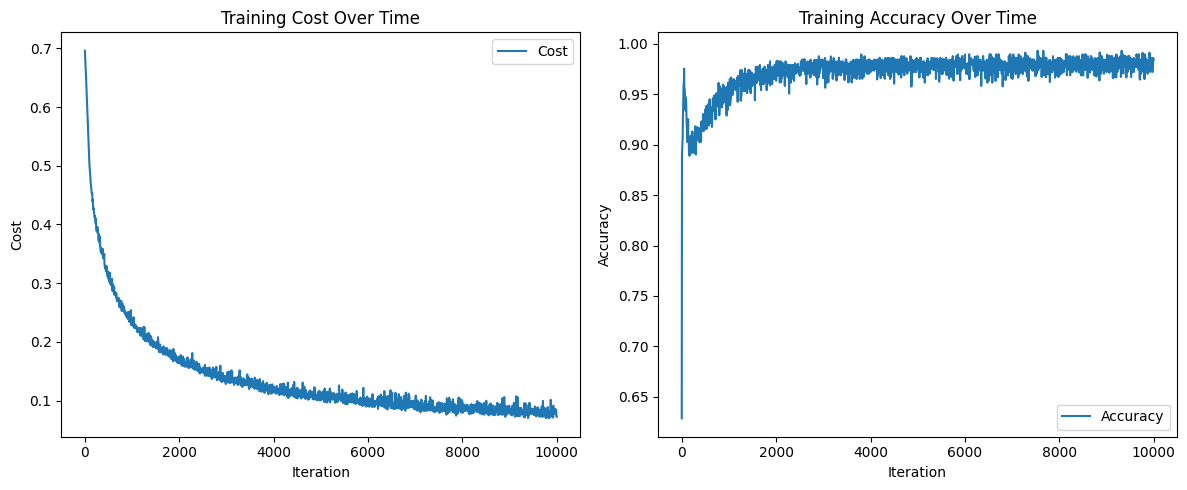


Validation accuracy: 0.9825


In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X = data.data.T          # (features, N)
y = data.target.reshape(1, -1)  # (1, N)

X = StandardScaler().fit_transform(X.T).T

X_train, X_val, y_train, y_val = train_test_split(
    X.T, y.T, test_size=0.2, random_state=42
)
X_train, X_val = X_train.T, X_val.T
y_train, y_val = y_train.T, y_val.T


model = MyNeuralNetwork([X.shape[0], 6, 1], None, True, "sigmoid", 0.01, 1.0, 0.001)

model.train(X, y, 10000, 64)

# 验证集评估
val_pred = model.forward(X_val)
val_acc = model.accuracy(val_pred, y_val)
print(f"\nValidation accuracy: {val_acc:.4f}")
